<a href="https://colab.research.google.com/github/andreavitaletti/colab/blob/main/Abstract_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This work is based on https://www.kaggle.com/code/nechbamohammed/abstract-clustering-for-scientific-paper-insights

In [ ]:
# https://www.kaggle.com/code/nechbamohammed/abstract-clustering-for-scientific-paper-insights
# https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing

!pip install bertopic
!pip install minisom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

In [ ]:
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)

In [ ]:
import pandas as pd                                        #Data processing, CSV files I/O (e.g. pd.read_csv)
import numpy as np                                         #Linear Algebra: Matrices ...
import matplotlib.pyplot as plt                            #Data Visualisation
import seaborn as sns
from bertopic import BERTopic

from tqdm import tqdm
# I discoverd that it's possible to download models for the specific purpose to preprocess scientific texts
# In the spacy docs I found a specific model for this : https://spacy.io/universe/project/scispacy
# Downloading en_core_sci_lg model to preprocess abstracts
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [ ]:
#Import NLP librarys and the spacy package to preprocess the abstract text
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #import commen list of stopword
import en_core_sci_lg  # import downlaoded model
import string
from minisom import MiniSom
from sklearn.cluster import SpectralClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
df =  pd.read_csv("scopus_vitaletti_abstracts.csv")
df.head(5)

,Authors,Author full names,Author(s) ID,Title,Year,Volume,Issue,Art. No.,Page start,Page end,Page count,Cited by,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source
0,Becchetti L.; Colesanti U.M.; Marchetti-Spacca...,"Becchetti, Luca (56218807100); Colesanti, Ugo ...",56218807100; 24073192000; 7004071298; 6506463530,Recommending items in pervasive scenarios: Mod...,2011,28,3,NaN,555,578.0,23.0,9,10.1007/s10115-010-0338-4,https://www.scopus.com/inward/record.uri?eid=2...,"In this paper, we propose and investigate the ...",Collaborative filtering; Decentralized recomme...,Aggregates; Behavioral research; Collaborative...,Article,Scopus
1,Chatzigiannakis I.; Mylonas G.; Vitaletti A.,"Chatzigiannakis, Ioannis (6602645904); Mylonas...",6602645904; 36846385500; 6506463530,"Urban pervasive applications: Challenges, scen...",2011,5,1,NaN,103,118.0,15.0,26,10.1016/j.cosrev.2010.09.003,https://www.scopus.com/inward/record.uri?eid=2...,"In this work, we discuss various aspects of th...",Challenges; Games; NFC; Participatory; Pervasi...,NaN,Article,Scopus
2,Becchetti L.; Leonardi S.; Marchetti-Spaccamel...,"Becchetti, L. (56218807100); Leonardi, S. (563...",56218807100; 56366507000; 7004071298; 65064635...,Parallel scheduling problems in next generatio...,2005,45,1,NaN,9,22.0,13.0,1,10.1002/net.20045,https://www.scopus.com/inward/record.uri?eid=2...,Next-generation 3G/4G wireless data networks a...,CDMA; Convex programming; On-line algorithms; ...,Algorithms; Code division multiple access; Opt...,Article,Scopus
3,Pennino D.; Pizzonia M.; Vitaletti A.; Zecchin...,"Pennino, Diego (57207940361); Pizzonia, Mauriz...",57207940361; 6603249368; 6506463530; 57215119316,Blockchain as IoT Economy Enabler: A Review of...,2022,11,2,20.0,NaN,NaN,NaN,19,10.3390/jsan11020020,https://www.scopus.com/inward/record.uri?eid=2...,"In the IoT-based economy, a large number of su...",applications of IoT and blockchain; blockchain...,NaN,Review,Scopus
4,Santini S.; Roemer K.; Couderc P.; Marrón P.J....,"Santini, Silvia (35303602900); Roemer, Kay (35...",35303602900; 35867822000; 22333533900; 6603114...,System Architectures and Programming Models,2010,NaN,NaN,NaN,347,404.0,57.0,0,10.1002/9780470610817.ch5,https://www.scopus.com/inward/record.uri?eid=2...,[No abstract available],Database view; Node internals; Programming mod...,NaN,Book chapter,Scopus


In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
my_stopwords = ["abstract","sunrise","available","address","propose","problem","request","code","deluge"]

In [ ]:
# Parser
parser = en_core_sci_lg.load()
# parser.max_length = 7000000 #Limit the size of the parser

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations and word not in my_stopwords ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens])
    return mytokens


In [ ]:
punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

['after',
 'whereupon',
 'at',
 'what',
 'seemed',
 'whoever',
 'beside',
 'namely',
 'or',
 'most']

In [ ]:
# the dataframe contains still hugh amount of data. The process the data faster I reduce the df to 10000 rows
# The scope of the notebook is not to analyze all data
# df = df.sample(10000, random_state=42)

In [ ]:
tqdm.pandas()
df["processed_text"] = df["Abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 90/90 [00:04<00:00, 20.23it/s]


In [ ]:
df['Abstract']

In [ ]:
df["processed_text"]

0     paper investigate effectiveness fully decentra...
1     work discuss aspect application pervasive tech...
2     next-generation 3g/4 g wireless datum network ...
3     iot-based economy large number subject company...
4                                                      
                            ...                        
85    paper tackle design simple localized low energ...
86    smart city leverage information communication ...
87    focus assessment environmental noise pollution...
88    paper standard mobile datum technology cellula...
89    bluepleiades bluetooth scatternet formation pr...
Name: processed_text, Length: 90, dtype: object

In [ ]:
!pip install wordcloud

In [ ]:
abstracts=""
for abstract in df["processed_text"]:
  abstracts=abstracts+" "+abstract

In [ ]:
abstracts_l=list(abstracts.split(" "))

In [ ]:
from collections import Counter
counts = Counter(abstracts_l)
print(counts)
# counts.most_common(3)

Counter({'datum': 94, 'use': 89, 'user': 79, '©': 74, 'network': 74, 'paper': 68, 'sensor': 66, 'protocol': 49, 'provide': 48, 'result': 47, 'present': 45, 'performance': 44, 'algorithm': 43, 'node': 42, 'design': 40, 'system': 39, 'application': 39, 'approach': 38, 'information': 36, 'blockchain': 36, 'solution': 34, 'wireless': 33, 'time': 29, 'base': 29, 'energy': 29, 'technique': 28, 'decentralized': 27, 'device': 26, 'technology': 25, 'implementation': 25, 'new': 24, 'real': 24, 'model': 24, 'study': 24, 'service': 24, 'smart': 23, 'implement': 23, 'consider': 23, 'process': 23, 'work': 22, 'discuss': 22, 'support': 22, 'message': 22, 'communication': 21, 'context': 21, 'management': 21, 'ieee': 21, 'require': 20, 'simulation': 20, 'privacy': 20, 'experimental': 19, 'number': 19, 'cost': 19, 'achieve': 18, 'different': 18, 'low': 18, 'assess': 17, 'simple': 17, 'environment': 17, 'highly': 17, 'feature': 17, 'case': 17, 'exchange': 16, 'need': 16, 'delay': 16, 'run': 16, 'experime

In [ ]:
min_threshold = 16
top = {x: count for x, count in counts.items() if count >= min_threshold}

In [ ]:
top

{'paper': 68,
 'decentralized': 27,
 'technique': 28,
 'use': 89,
 'system': 39,
 'device': 26,
 'communication': 21,
 'smart': 23,
 'information': 36,
 'user': 79,
 'new': 24,
 'exchange': 16,
 'algorithm': 43,
 'require': 20,
 'implement': 23,
 'assess': 17,
 'performance': 44,
 'simulation': 20,
 'real': 24,
 'datum': 94,
 'solution': 34,
 '©': 74,
 'work': 22,
 'discuss': 22,
 'application': 39,
 'technology': 25,
 'wireless': 33,
 'sensor': 66,
 'network': 74,
 'provide': 48,
 'context': 21,
 'support': 22,
 'model': 24,
 'time': 29,
 'present': 45,
 'result': 47,
 'simple': 17,
 'experimental': 19,
 'study': 24,
 'number': 19,
 'service': 24,
 'implementation': 25,
 'blockchain': 36,
 'need': 16,
 'consider': 23,
 'cost': 19,
 'protocol': 49,
 'management': 21,
 'message': 22,
 'node': 42,
 'delay': 16,
 'design': 40,
 'run': 16,
 'experiment': 16,
 'collect': 16,
 'ieee': 21,
 'process': 23,
 'approach': 38,
 'achieve': 18,
 'environment': 17,
 'analysis': 16,
 'highly': 17,
 'p

In [ ]:
l=[]
for i in top:
  l.append(i)
print(l)

['paper', 'decentralized', 'technique', 'use', 'system', 'device', 'communication', 'smart', 'information', 'user', 'new', 'exchange', 'algorithm', 'require', 'implement', 'assess', 'performance', 'simulation', 'real', 'datum', 'solution', '©', 'work', 'discuss', 'application', 'technology', 'wireless', 'sensor', 'network', 'provide', 'context', 'support', 'model', 'time', 'present', 'result', 'simple', 'experimental', 'study', 'number', 'service', 'implementation', 'blockchain', 'need', 'consider', 'cost', 'protocol', 'management', 'message', 'node', 'delay', 'design', 'run', 'experiment', 'collect', 'ieee', 'process', 'approach', 'achieve', 'environment', 'analysis', 'highly', 'privacy', 'base', 'feature', 'case', 'plant', 'different', 'right', 'energy', 'low']


In [ ]:
for not_relevant in ['paper', 'technique', 'node', 'implement','smart',  'use', 'new', 'exchange',  'require',  'assess',  'real',  '©', 'work', 'discuss',  'technology',  'provide', 'context', 'support',  'time', 'present', 'result', 'simple',  'number',   'need', 'consider',  'management', 'message',    'run',   'ieee', 'process', 'approach', 'achieve', 'environment',  'highly',  'base', 'feature', 'case', 'different', 'right', 'low']:
  del top[not_relevant]



In [ ]:
import csv
with open('dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["weight","word"])
    for key, value in top.items():
       writer.writerow([value,key])

# To be used with https://www.wordclouds.com/
# I like the graphical result

(-0.5, 399.5, 199.5, -0.5)

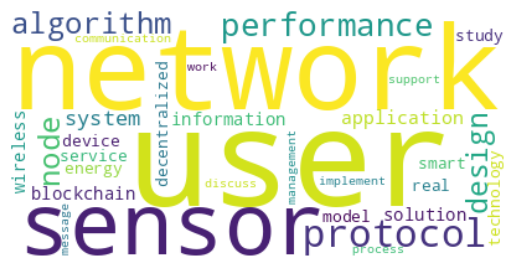

In [ ]:
from wordcloud import WordCloud, STOPWORDS
#wordcloud = WordCloud(background_color="white", max_words=100, stopwords=stopwords).generate(abstracts)
#wordcloud = WordCloud(background_color="white", max_words=10, stopwords=stopwords).generate(abs)
wordcloud = WordCloud(background_color="white").generate_from_frequencies(top)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [ ]:
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L6-v2", min_topic_size=2)
topics, probs = topic_model.fit_transform(df["processed_text"].to_numpy()); len(topic_model.get_topic_info())



2024-07-01 13:45:50,347 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2024-07-01 13:46:04,108 - BERTopic - Embedding - Completed ✓
2024-07-01 13:46:04,111 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-01 13:46:15,343 - BERTopic - Dimensionality - Completed ✓
2024-07-01 13:46:15,348 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-01 13:46:15,412 - BERTopic - Cluster - Completed ✓
2024-07-01 13:46:15,432 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-01 13:46:15,510 - BERTopic - Representation - Completed ✓


13

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10,-1_gms_use_maintenance_company,"[gms, use, maintenance, company, performance, ...",[artificial intelligence-based ai analysis lar...
1,0,16,0_sensor_network_datum_wireless,"[sensor, network, datum, wireless, node, algor...",[sensor network consist sensing device exchang...
2,1,11,1_blockchain_decentralized_identity_nft,"[blockchain, decentralized, identity, nft, sub...",[italian craft beer market small brewery pub l...
3,2,10,2_user_information_exchange_use,"[user, information, exchange, use, phone, tag,...",[paper investigate effectiveness fully decentr...
4,3,9,3_protocol_node_dtn_network,"[protocol, node, dtn, network, performance, te...",[paper new taxonomy delay tol- erant network d...
5,4,6,4_datum_clinical_trial_personal,"[datum, clinical, trial, personal, world, clie...",[era internet thing iot drug developer potenti...
6,5,5,5_product_process_design_technology,"[product, process, design, technology, user, a...",[gende http://www.gende.it tool allow designer...
7,6,5,6_robinson_list_poc_decentralised,"[robinson, list, poc, decentralised, subscribe...","[, robinson list adopt country protect phone s..."
8,7,4,7_result_simulator_testbed_infrastructure,"[result, simulator, testbed, infrastructure, s...",[present discuss challenge solution pose desig...
9,8,4,8_signal_plant_stimulus_electrical,"[signal, plant, stimulus, electrical, feature,...",[plant electrical signal contain low frequency...


In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'


In [ ]:
# https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html

topic_model.visualize_barchart(top_n_topics=3, height=700)


In [ ]:


topic_model.visualize_term_rank()



In [ ]:

topic_model.visualize_topics(top_n_topics=21)
topic_model.visualize_topics().show()



In [ ]:


topic_model.visualize_hierarchy(top_n_topics=21, width=800)



In [ ]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=21)

In [ ]:
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
topic_model.visualize_documents(df["Title"])

jq -M 'del(.metadata.widgets)' Abstract_Analysis.ipynb > Abstract_Analysis_new.ipynb

jupyter nbconvert --to html Abstract_Analysis_new.ipynb